**ASSET ANALYSIS**

ASSET test on fMRI data provided by J. Schreiber.

There are 300 time points (similar to binned spike trains) for 33865 source locations


In [1]:
# import packages

import numpy as np
import sys
import neo
import quantities as pq
sys.path.append('./ASSET/')
import asset
import matplotlib.pyplot as plt

In [2]:
path = '../../ASSET_fMRI/'

# data preprocessing in preprocessing_data.py file
sts = np.load(path + 'activations_st.npy')

# take only the first N channels
number_of_channels = 33865
sts = sts[0:number_of_channels]
path = path + str(number_of_channels) + '/'

Step 1:

Build the intersection matrix (imat) and the associated probability matrix (pmat) with the desired binsize. Here we use 1s.


In [3]:
binsize = 1 * pq.s
dt = 300 * pq.s

In [ ]:
# build the intersection matrix and save it
imat, xedges, yedges = asset.intersection_matrix(sts, binsize, dt, norm=2)
np.save(path + 'imat%i.npy' % number_of_channels, imat)
np.save(path + 'xedges%i.npy' % number_of_channels, xedges)
np.save(path + 'yedges%i.npy' % number_of_channels, yedges)

In [4]:
# load the already computed intersection matrix
imat = np.load(path + 'imat%i.npy' % number_of_channels)
xedges = np.load(path + 'xedges%i.npy' % number_of_channels)
yedges = np.load(path + 'yedges%i.npy' % number_of_channels)

In [ ]:
# calculate the probability matrix and save it
pmat, xedges, yedges = asset.probability_matrix_analytical(spiketrains=sts,
                                                           binsize=binsize,
                                                           dt=dt,
                                                           kernel_width=10*pq.s)
np.save(path + 'pmat%i.npy' % number_of_channels, pmat)

In [5]:
# load the already computed probability matrix
pmat = np.load(path + 'pmat%i.npy' % number_of_channels)

Step 2:

Compute the joint probability matrix jmat, using a suitable filter

In [12]:
filter_shape = (5,2)  # filter shape
nr_neigh = 5  # nr of largest neighbors
# calculate the joint probability matrix
jmat = asset.joint_probability_matrix(pmat, filter_shape, nr_neigh)
np.save(path + 'jmat%i.npy' % number_of_channels, jmat)

/home/stella/Documents/Juelich/projects/forks/pcp_use_cases/ASSET/asset.py:1189: RuntimeWarning: divide by zero encountered in log
  dU_log = np.log(dU)


In [6]:
# load the joint probability matrix
jmat = np.load(path + 'jmat%i.npy' % number_of_channels)

Step 3:

Create from pmat and jmat a masked version of the intersection matrix

In [13]:
alpha1 = 0.99
alpha2 = 0.99999
mask = asset.mask_matrices([pmat, jmat], [alpha1, alpha2])
np.save(path + 'mask%i.npy' % number_of_channels, mask)

In [7]:
# load the masked matrix
mask = np.load(path + 'mask%i.npy' % number_of_channels)

Step 4:

Cluster significant elements of imat into diagonal structures ("DSs")

In [14]:
epsilon = 10
minsize = 2
stretch = 2

cmat = asset.cluster_matrix_entries(mask, epsilon, minsize, stretch)
np.save(path + 'cmat%i.npy' % number_of_channels, cmat)

/home/stella/Documents/Juelich/projects/forks/pcp_use_cases/ASSET/asset.py:725: RuntimeWarning: divide by zero encountered in true_divide
  AngCoeff = dY / dX
/home/stella/Documents/Juelich/projects/forks/pcp_use_cases/ASSET/asset.py:725: RuntimeWarning: invalid value encountered in true_divide
  AngCoeff = dY / dX


In [8]:
cmat = np.load(path + 'cmat%i.npy' % number_of_channels)

Step 5:

Extract sequences of synchronous events associated to each worm

In [15]:
sse = asset.extract_sse(sts, xedges, yedges, cmat)
np.save(path + 'sse%i.npy' % number_of_channels, sse)

In [16]:
# peak of the results
'''
sse : dict
    a dictionary D of SSEs, where each SSE is a sub-dictionary Dk,
    k=1,...,K, where K is the total number of clusters in cmat:

    .. centered:: D = {1: D1, 2: D2, ..., K: DK}

    Each sub-dictionary Dk represents the k-th diagonal structure
    (i.e. the k-th cluster) in cmat, and is of the form

    .. centered:: Dk = {(i1, j1): S1, (i2, j2): S2, ..., (iL, jL): SL}.

    The keys (i, j) represent the positions (time bin ids) of all
    elements in cmat that compose the SSE, i.e. that take value l (and
    therefore belong to the same cluster), and the values Sk are sets of
    neuron ids representing a repeated synchronous event (i.e. spiking
    at time bins i and j).

'''
sse = np.load(path + 'sse%i.npy' % number_of_channels)
sse[1]

IndexError: too many indices for array

AttributeError: 'numpy.ndarray' object has no attribute 'keys'

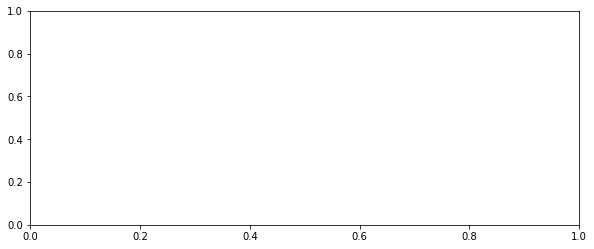

In [11]:
# plotting of the SSEs found in the data
inch2cm = 0.3937
fig1 = plt.figure(figsize=(25*inch2cm, 10*inch2cm))
ax1 = fig1.add_subplot(111)
number_sses = len(sse.keys())
for i, st in enumerate(sts):
    for n in st:
        ax1.set_xlim(0, 300)
        ax1.set_ylim(-0.1, 100.1)
        ax1.set_xlabel('time')
        ax1.set_ylabel('neurons')
        ax1.plot(n, i, '.', color='c')
for index_sse in range(1, number_sses):
    # number_repetitions = len(sse[index_sse])
    for key, value in sse[index_sse].items():
        for bin_item in key:
            for neuron in value:
                ax1.set_xlim(0, 300)
                ax1.set_ylim(-0.1, 10.1)
                ax1.set_xlabel('time')
                ax1.set_ylabel('neurons')
                ax1.set_title('SSEs extracted by ASSET')
                ax1.plot(bin_item, neuron, '.', color='r')
plt.show()